# Themes-based Approach

In [1]:
import pandas as pd
from numpy import loadtxt
import numpy as np
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

In [2]:
#Calculating Silhouette Averages to determine optimal k value
def optimal_kmeans(upper_n, X):
    range_n_clusters = list(range(2,upper_n))
    best_score = 0
    optimal_k = 0

    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        #print("For n_clusters =", n_clusters,
        #      "The average silhouette_score is :", silhouette_avg)
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            optimal_k = n_clusters
            clusters = cluster_labels

    print(f'Optimal k = {optimal_k}')
    
    return clusters, optimal_k

In [3]:
data = pd.read_csv("F.txt", delimiter = "\t", names = ["V1", "V2", "V3", "V4"])

In [4]:
voices = ["V1", "V2", "V3", "V4"]
for v in voices:
    prev = 0
    data[v+"-Diff"] = 0 #creating difference representations needed for clustering (according to Dirst)
    for index, row in data.iterrows():
        data[v+"-Diff"][index] = row[v] - prev
        prev = row[v]

In [5]:
voices_diff = ["V1-Diff", "V2-Diff", "V3-Diff", "V4-Diff"]
voices_l = []

for v in voices_diff:
    voices_l.append(data[v].tolist())

voices_l = [item for sublist in voices_l for item in sublist] #to flatten the list
data.drop(columns = ["V1-Diff", "V2-Diff", "V3-Diff", "V4-Diff"], inplace = True) #is not needed anymore

Text(0, 0.5, 'Pitch')

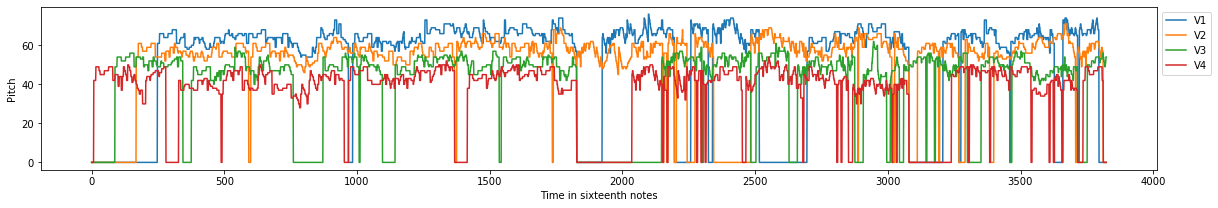

In [6]:
plt.figure(figsize = (20,3))
plt.plot(data)
plt.legend(["V1", "V2", "V3", "V4"], bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("Time in sixteenth notes")
plt.ylabel("Pitch")

In [7]:
window = 32 #at each point we record 32 notes (2 bars)
step_size = 8 #half a bar = 8
stop = window - step_size

X = np.empty((0,window), int)
for i in range(0, len(voices_l)-stop, step_size): #int(window/3)): #we advance the window by 16 steps (minus 24 to make up for the difference)
    X = np.vstack((X, voices_l[i:i+window]))

print(len(X))

1909


In [8]:
clusters, optimal_k = optimal_kmeans(50, X) #there are 46 unique notes
#Dirst explaines that the optimal k will lie close to the num of unique notes. Thus, we test up to k = 50

Optimal k = 42


In [9]:
unique_clusters = np.unique(clusters) #extract unique clusters
adjacent_clusters = dict()
prev = False
for c in unique_clusters: 
    c_dict = dict.fromkeys(unique_clusters,0) #create a dict per cluster with each cluster as key, values = 0
    for val in clusters:
        if prev == c:
            c_dict[val] += 1 #if the previous value is equal to the current, increment dict value by 1

        prev = val

    adjacent_clusters[c] = c_dict #dict of dicts


    partial_themes = dict(zip(unique_clusters, [-1]*optimal_k)) #-1 because one cluster = 0
for i in range(len(adjacent_clusters)):
    num_non_zero_values = 0
    for key, value in adjacent_clusters[i].items():
        if value != 0:
            num_non_zero_values += 1
            adjacent_part_of_theme = key

    if num_non_zero_values == 1: #if a cluster is consistently followed by another one, they form a theme
        partial_themes[i] = adjacent_part_of_theme #key is first cluster, value latter cluster of theme

In [10]:
#analyzing clusters
partial_themes = dict(zip(unique_clusters, [-1]*optimal_k)) #-1 because one cluster = 0
for i in range(len(adjacent_clusters)):
    num_non_zero_values = 0
    for key, value in adjacent_clusters[i].items():
        if value != 0:
            num_non_zero_values += 1
            adjacent_part_of_theme = key
    
    if num_non_zero_values == 1: #if a cluster is consistently followed by another one, they form a theme
        partial_themes[i] = adjacent_part_of_theme #key is first cluster, value latter cluster of theme

In [11]:
themes = clusters.copy()
for i in range(len(clusters)):
    #print(i)
    if i > 0:
        if clusters[i] == partial_themes[clusters[i-1]]:
            new_theme_code = int( str(clusters[i-1]) + str(clusters[i]))
            themes[i-1] = new_theme_code
            themes[i] = new_theme_code

In [12]:
unique_themes = np.unique(themes)
adjacent_themes = dict()
prev = False
for t in unique_themes:
    t_dict = dict.fromkeys(unique_themes,0)
    for val in themes:
        if prev == t:
            t_dict[val] += 1
            
        prev = val
    
    adjacent_themes[t] = t_dict   
    

partial_themes = dict(zip(unique_themes, [-1]*45)) #-1 because one cluster = 0
for theme in unique_themes:
    num_non_zero_values = 0
    for key, value in adjacent_themes[theme].items():
        #print(key, adjacent_themes[theme])
        if value != 0:
            num_non_zero_values += 1
            adjacent_part_of_theme = key
    
    if num_non_zero_values == 1: #if a cluster is consistently followed by another one, they form a theme
        partial_themes[theme] = adjacent_part_of_theme #key is first cluster, value latter cluster of theme

In [13]:
themes_new = themes.copy()
for i in range(len(themes_new)):
    #print(i)
    if i > 0:
        if themes_new[i] == partial_themes[themes_new[i-1]]:
            themes_new[i] = themes_new[i-1]    

In [14]:
unique_themes_new = np.unique(themes_new)
print(len(unique_themes_new)) #the final number of unique themes

29


In [15]:
adjacent_themes_new = dict()
prev = False
for t in unique_themes_new:
    t_dict = dict.fromkeys(unique_themes_new,0)
    for val in themes_new:
        if prev == t:
            t_dict[val] += 1
            
        prev = val
    
    adjacent_themes_new[t] = t_dict 

In [16]:
#Calculating the transition matrix
Transition = []
for theme in unique_themes_new:
    row = list(adjacent_themes_new[theme].values())
    Transition.append(row)
    
for i in range(0,len(Transition)):
    s=sum(Transition[i]) #sum of counts per row (i.e. per pitch)
    for j in range(0,len(Transition[i])):
        Transition[i][j]=Transition[i][j]/s #probability per column

In [17]:
voices_x = []
for v in voices:
    voices_x.append(data[v].tolist())
voices_x = [item for sublist in voices_x for item in sublist] #to flatten the list
#len(set(voices_x)) #46

In [18]:
unique_windows = []
Z = np.empty((0,window), int)
for i in range(0, len(voices_x)-stop,step_size):
    unique_windows.append(voices_x[i:i+window])
    Z = np.vstack((Z, voices_x[i:i+window]))
unique_windows = [list(x) for x in set(tuple(x) for x in unique_windows)]

In [19]:
#Calculating the emission matrix
Emission=np.zeros([len(unique_themes_new),len(unique_windows)]) #cluster as rows, windows as columns
for i in range(len(unique_themes_new)):
    indices = [x for x, c in enumerate(list(themes_new)) if c == unique_themes_new[i]] #get the indices per cluster
    theme_windows = Z[indices] #windows per theme
    for tw in theme_windows:   
        for cnt, w in enumerate(unique_windows):
            if list(tw) == w:
                Emission[i][cnt] += 1

for i in range(0,len(Emission)):
    Emission[i]=Emission[i]/sum(Emission[i])

In [20]:
obs_pred = [] #empty lists for predicted observable / hidden states
hid_pred = []
count = 1 #to determine prediction period
offset = 0 #to find starting theme per voice
#to be able to translate themes to values from 0 to len(unique_themes_new) to work with matrices
themes_order_dict = dict(zip(unique_themes_new, range(len(unique_themes_new))))
for v in voices:
    v_pred = []
    h_pred = []
    start = (len(data[v])//step_size) - (window//step_size) + offset #to figure out the initial hidden state
    #print(start)

    current_theme = themes_new[start] #the current theme for pred = the last theme of the voice in training data
    hidden_state = themes_order_dict[current_theme] #position of theme in matrix
    
    while(count<8): #7*32 > 200 notes ~ 25 sec play time
        next_theme = int(np.random.choice(unique_themes_new,1,p=Transition[hidden_state]))
        hidden_state = themes_order_dict[next_theme]
        
        observable_state_index = np.random.choice(list(range(len(unique_windows))),p=Emission[hidden_state])
        observable_state = unique_windows[observable_state_index]
        
        v_pred.append(observable_state)
        h_pred.append(hidden_state)
        
        count += 1
        
    obs_pred.append(v_pred)
    hid_pred.append(h_pred)
        
    offset += len(data[v])//step_size
    
    count = 1

In [21]:
data_pred = pd.DataFrame({"V1": [item for sublist in obs_pred[0] for item in sublist],
                        "V2": [item for sublist in obs_pred[1] for item in sublist],
                        "V3": [item for sublist in obs_pred[2] for item in sublist],
                        "V4": [item for sublist in obs_pred[3] for item in sublist]})

In [22]:
data_final=data.append(data_pred,ignore_index="True")

In [23]:
data_pred.to_csv("model_themes_pred.txt",sep="\t",header=False,index=False) #prediction only

In [24]:
len(data_pred["V1"]) # appended notes per Voice

224

In [25]:
data_final.to_csv("model_themes.txt",sep="\t",header=False,index=False) #original + prediction